In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import dreams.utils.mols as mu
import dreams.utils.data as du
import dreams.api as api
from dreams.utils.plots import init_plotting, save_fig, get_nature_hex_colors
from dreams.definitions import *
tqdm.pandas()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# msdata = du.MSData.load(NIST20 / 'nist20_clean_A.pkl', spec_col='PARSED PEAKS', prec_mz_col='PRECURSOR M/Z', adduct_col='ADDUCT', charge_col='CHARGE', mol_col='ROMol')
msdata = du.MSData(NIST20 / 'nist20_clean_A.hdf5')
df = msdata.to_pandas(ignore_cols=[DREAMS_EMBEDDING, SPECTRUM])
df

#C  #Cl  #F  #N  #O  #P  #S      CASNO COLLISION ENERGY COLLISION GAS  \
0       45    0   0   0  13   1   0  223794341                2            N2   
1       44    0   0   1   8   1   0    4235954               18            N2   
2       44    0   0   1   8   1   0    4235954               35            N2   
3       44    0   0   1   8   1   0    4235954               27            N2   
4       44    0   0   1   8   1   0    4235954               30            N2   
...     ..  ...  ..  ..  ..  ..  ..        ...              ...           ...   
355214  46    0   0   1  11   0   1        nan     NCE=27% 49eV            N2   
355215  46    0   0   1  11   0   1        nan     NCE=35% 61eV            N2   
355216  46    0   0   1  11   0   1        nan    NCE=65% 109eV            N2   
355217  46    0   0   1  11   0   1        nan    NCE=76% 126eV            N2   
355218  46    0   0   1  11   0   1        nan          NCE=35%            N2   

        ...                                              NOTES NUM PEAKS  \
0       ...  Water/isopropanol/Formic acid; added_Vial_ID=6039        11   
1       ...  Consensus spectrum; Water/isopropanol/Formic a...         5   
2       ...  Consensus spectrum; Water/isopropanol/Formic a...         4   
3       ...  Water/isopropanol/Formic acid; added_Vial_ID=1...        23   
4       ...  Water/isopropanol/Formic acid; added_Vial_ID=1...        16   
...     ...                                                ...       ...   
355214  ...  micromol/L in water/acetonitrile/formic acid (...        56   
355215  ...  micromol/L in water/acetonitrile/formic acid (...        46   
355216  ...  micromol/L in water/acetonitrile/formic acid (...        18   
355217  ...  micromol/L in water/acetonitrile/formic acid (...         7   
355218  ...  micromol/L in water/acetonitrile/formic acid (...        41   

       PRECURSOR TYPE RELATED CASNO           SAMPLE INLET SPECTRUM TYPE  \
0              [M+H]+     799268534  direct flow injection           MS2   
1              [M+H]+           nan  direct flow injection           MS2   
2              [M+H]+           nan  direct flow injection           MS2   
3             [M+Na]+           nan  direct flow injection           MS2   
4             [M+Na]+           nan  direct flow injection           MS2   
...               ...           ...                    ...           ...   
355214         [M+H]+           nan  direct flow injection           MS2   
355215         [M+H]+           nan  direct flow injection           MS2   
355216         [M+H]+           nan  direct flow injection           MS2   
355217         [M+H]+           nan  direct flow injection           MS2   
355218         [M+H]+           nan  direct flow injection           MS2   

                                                 SYNONYMS charge precursor_mz  \
0       1,2-Di-(9Z-octadecenoyl)-sn-glycero-3-phospho-...      1     863.5644   
1       1,2-Dioleoyl-sn-glycero-3-PC\n3,5,9-Trioxa-4-p...      1     786.6007   
2       1,2-Dioleoyl-sn-glycero-3-PC\n3,5,9-Trioxa-4-p...      1     786.6007   
3       1,2-Dioleoyl-sn-glycero-3-PC\n3,5,9-Trioxa-4-p...      1     808.5827   
4       1,2-Dioleoyl-sn-glycero-3-PC\n3,5,9-Trioxa-4-p...      1     808.5827   
...                                                   ...    ...          ...   
355214  Sulfoglycosphingolipid N-docosanoyl-1-.beta.-(...      1     864.6229   
355215  Sulfoglycosphingolipid N-docosanoyl-1-.beta.-(...      1     864.6229   
355216  Sulfoglycosphingolipid N-docosanoyl-1-.beta.-(...      1     864.6229   
355217  Sulfoglycosphingolipid N-docosanoyl-1-.beta.-(...      1     864.6229   
355218  Sulfoglycosphingolipid N-docosanoyl-1-.beta.-(...      1     864.6229   

                                                   smiles  
0       CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...  
1       CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...  
2       CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])..

In [3]:
# embs = api.dreams_intermediates(PRETRAINED / 'ssl_model.ckpt', msdata, batch_size=32, attention_matrices=False)
embs = msdata[DREAMS_EMBEDDING]
print(embs.shape)

(355219, 1024)


In [5]:
df['inchi14'] = df[SMILES].progress_apply(mu.smiles_to_inchi14)
print(df['inchi14'].nunique(), df[SMILES].nunique())

100%|██████████| 355219/355219 [01:08<00:00, 5199.29it/s]


24703 25106


In [11]:
# Set the number of neighbors for KNN
k_values = [1, 3, 5, 10]

# Initialize list to store results
results = []

# Set up for random sampling
num_samples = 100_000
np.random.seed(42)

# Compute k-NN accuracy scores for different numbers of components and k values
for n_components in tqdm([2, 10, 256, 512, embs.shape[1] - 1], desc="PCA components"):
    # Perform PCA
    embs_pca_n = StandardScaler().fit_transform(embs)
    pca = PCA(n_components=n_components)
    embs_pca_n = pca.fit_transform(embs_pca_n)
    
    for k in tqdm(k_values, desc=f"{k} values (n_components={n_components})", leave=False):
        # Get indices of dataframe rows which have inchi14 value present at least k times in the whole dataset
        inchi14_counts = df['inchi14'].value_counts()
        frequent_inchi14 = inchi14_counts[inchi14_counts >= k].index
        indices = df[df['inchi14'].isin(frequent_inchi14)].index
        
        # Randomly sample indices
        random_indices = np.random.choice(indices, max(num_samples, len(indices)), replace=False)
        
        # Initialize and fit the KNN classifier
        neigh = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=None)
        neigh.fit(embs_pca_n, df['inchi14'])
        
        true_smiles = df['inchi14'].iloc[random_indices]
        predicted_smiles = []
        batch_size = 500

        # Predict in batches to improve performance
        for i in tqdm(range(0, len(random_indices), batch_size), desc="Predicting", leave=False, disable=True):
            batch_indices = random_indices[i:i+batch_size]
            batch_predictions = neigh.predict(embs_pca_n[batch_indices])
            predicted_smiles.extend(batch_predictions)

        # Calculate accuracy and store results
        accuracy = accuracy_score(true_smiles, predicted_smiles)
        results.append({'n_components': n_components, 'k': k, 'accuracy': accuracy})

# Create DataFrame from results
results_df = pd.DataFrame(results)

PCA components: 100%|██████████| 5/5 [9:46:28<00:00, 7037.70s/it]               


In [13]:
results_df.to_csv('adducts_knn_accuracy.csv', index=False)

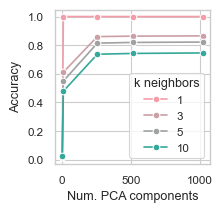

In [27]:
# Plot results
init_plotting(figsize=(2, 2))
sns.lineplot(
    x='n_components', y='accuracy', hue='k', data=results_df, marker='o',
    palette=sns.blend_palette(reversed(get_nature_hex_colors()[1:3]), as_cmap=True)
)
plt.xlabel('Num. PCA components')
plt.ylabel('Accuracy')
plt.legend(title='k neighbors')
save_fig('ssl_pca_knn_accuracy.svg')
plt.show()

In [28]:
results_df

n_components   k  accuracy
0              2   1  0.022375
1              2   3  0.022429
2              2   5  0.022444
3              2  10  0.023666
4             10   1  0.999904
5             10   3  0.611417
6             10   5  0.549118
7             10  10  0.478671
8            256   1  0.999904
9            256   3  0.859682
10           256   5  0.814141
11           256  10  0.736625
12           512   1  0.999904
13           512   3  0.863077
14           512   5  0.819041
15           512  10  0.742201
16          1023   1  0.999904
17          1023   3  0.864707
18          1023   5  0.821602
19          1023  10  0.745730

In [8]:
common_adducts = ['[M+H]+', '[M+Na]+', '[2M+H]+']
df_common_adducts = df[df['PRECURSOR TYPE'].isin(common_adducts)]
df_common_adducts_gb = df_common_adducts.groupby('NAME').agg({'PRECURSOR TYPE': 'nunique'})
df_common_adducts_gb = df_common_adducts_gb[df_common_adducts_gb['PRECURSOR TYPE'] == len(common_adducts)]
df_common_adducts = df_common_adducts[df_common_adducts['NAME'].isin(df_common_adducts_gb.index.tolist())]
df_common_adducts = df_common_adducts.reset_index()
print(df_common_adducts['NAME'].nunique())
df_common_adducts

329


index  #C  #Cl  #F  #N  #O  #P  #S      CASNO COLLISION ENERGY  ...  \
0         25  24    0   0   1   7   1   0   17364168               10  ...   
1         26  24    0   0   1   7   1   0   17364168               15  ...   
2         27  24    0   0   1   7   1   0   17364168               20  ...   
3         28  24    0   0   1   7   1   0   17364168               30  ...   
4         29  24    0   0   1   7   1   0   17364168               40  ...   
...      ...  ..  ...  ..  ..  ..  ..  ..        ...              ...  ...   
6545  350185  20    0   0   2   2   0   0  354560126          NCE=76%  ...   
6546  350186  20    0   0   2   2   0   0  354560126          NCE=88%  ...   
6547  350187  20    0   0   2   2   0   0  354560126         NCE=100%  ...   
6548  350188  20    0   0   2   2   0   0  354560126         NCE=115%  ...   
6549  350189  20    0   0   2   2   0   0  354560126         NCE=130%  ...   

                                                  NOTES NUM PEAKS  \
0     Consensus spectrum; Water/isopropanol/Formic a...        31   
1     Consensus spectrum; Water/isopropanol/Formic a...        11   
2     Consensus spectrum; Water/isopropanol/Formic a...        13   
3     Consensus spectrum; Water/isopropanol/Formic a...        18   
4     Consensus spectrum; Water/isopropanol/Formic a...        19   
...                                                 ...       ...   
6545  micromol/L in water/acetonitrile/formic acid (...        16   
6546  micromol/L in water/acetonitrile/formic acid (...        18   
6547  micromol/L in water/acetonitrile/formic acid (...        18   
6548  micromol/L in water/acetonitrile/formic acid (...        17   
6549  micromol/L in water/acetonitrile/formic acid (...        13   

     PRECURSOR TYPE RELATED CASNO           SAMPLE INLET SPECTRUM TYPE  \
0           [M+Na]+           nan                     LC           MS2   
1           [M+Na]+           nan                     LC           MS2   
2           [M+Na]+           nan                     LC           MS2   
3           [M+Na]+           nan                     LC           MS2   
4           [M+Na]+           nan                     LC           MS2   
...             ...           ...                    ...           ...   
6545        [2M+H]+           nan  direct flow injection           MS2   
6546        [2M+H]+           nan  direct flow injection           MS2   
6547        [2M+H]+           nan  direct flow injection           MS2   
6548        [2M+H]+           nan  direct flow injection           MS2   
6549        [2M+H]+           nan  direct flow injection           MS2   

                                               SYNONYMS charge precursor_mz  \
0     Lysophosphatidylcholine(16:0)\nLyso-PC(16:0)\n...      1     518.3217   
1     Lysophosphatidylcholine(16:0)\nLyso-PC(16:0)\n...      1     518.3217   
2     Lysophosphatidylcholine(16:0)\nLyso-PC(16:0)\n...      1     518.3217   
3     Lysophosphatidylcholine(16:0)\nLyso-PC(16:0)\n...      1     518.3217   
4     Lysophosphatidylcholine(16:0)\nLyso-PC(16:0)\n...      1     518.3217   
...                                                 ...    ...          ...   
6545  Butanoic acid, 3-methyl-, [[4-[(4-methylphenyl...      1     649.3748   
6546  Butanoic acid, 3-methyl-, [[4-[(4-methylphenyl...      1     649.3748   
6547  Butanoic acid, 3-methyl-, [[4-[(4-methylphenyl...      1     649.3748   
6548  Butanoic acid, 3-methyl-, [[4-[(4-methylphenyl...      1     649.3748   
6549  Butanoic acid, 3-methyl-, [[4-[(4-methylphenyl...      1     649.3748   

                                                 smiles  
0     CCCCCCCCCCCCCCCC(=O)OCC(O)CO[P@SP](=O)([O-])OC...  
1     CCCCCCCCCCCCCCCC(=O)OCC(O)CO[P@SP](=O)([O-])OC...  
2     CCCCCCCCCCCCCCCC(=O)OCC(O)CO[P@SP](=O)([O-])OC...  
3     CCCCCCCCCCCCCCCC(=O)OCC(O)CO[P@SP](=O)([O-])OC...  
4     CCCCCCCCCCCCCCCC(=O)OCC(O)CO[P@SP](=O)([O-])OC...  
...                                                 ...

144
[0.09727809 0.08815354]


/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_8678/733777970.py:32: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(x=embs_pca[:, 0], y=embs_pca[:, 1], s=70, hue=df_adducts_subset['NAME'], alpha=0.9, style=df_adducts_subset['PRECURSOR TYPE'], palette=colors, size=df_adducts_subset['COLLISION ENERGY int'], sizes=(50, 130))


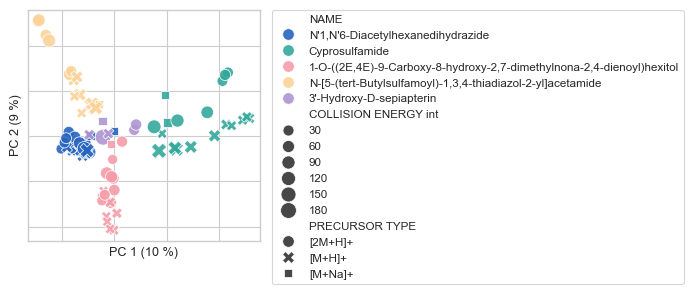

N'1,N'6-Diacetylhexanedihydrazide
258.132805
CC(=O)NNC(=O)CCCCC(=O)NNC(C)=O


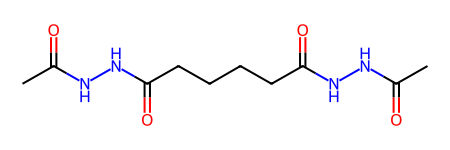

Cyprosulfamide
374.093643
COc1ccccc1C(=O)N[S@SP](=O)(=O)c1ccc(C(=O)NC2CC2)cc1


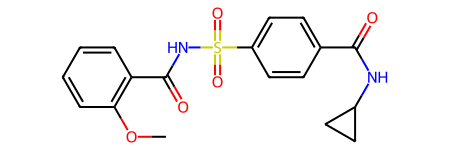

1-O-((2E,4E)-9-Carboxy-8-hydroxy-2,7-dimethylnona-2,4-dienoyl)hexitol
406.183897
C/C(=C\C=C\CC(C)C(O)CC(=O)O)C(=O)OCC(O)C(O)C(O)C(O)CO


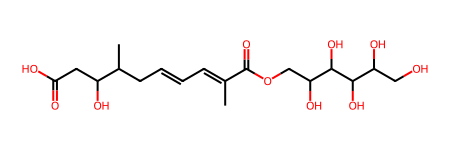

N-[5-(tert-Butylsulfamoyl)-1,3,4-thiadiazol-2-yl]acetamide
278.050732
CC(=O)Nc1nnc(S(=O)(=O)NC(C)(C)C)s1


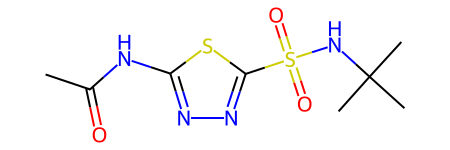

3'-Hydroxy-D-sepiapterin
253.081104
Nc1nc(=O)c2c([nH]1)NCC(C(=O)[C@H](O)CO)=N2


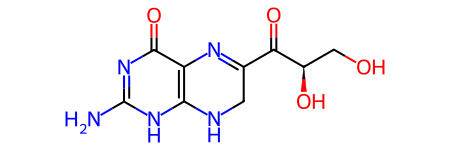

In [24]:
import umap
from rdkit import Chem
from dreams.utils.plots import get_nature_hex_colors, save_fig
colors = get_nature_hex_colors() + ['#A870B5']

i = 144

print(i)
df_adducts_subset = df_common_adducts[df_common_adducts['NAME'].isin(pd.Series(df_common_adducts['NAME'].unique()).sample(n=5, random_state=i))].sample(frac=1, random_state=4)
idx = df_adducts_subset.index.tolist()
# df_adducts_subset

df_adducts_subset['COLLISION ENERGY int'] = df_adducts_subset['COLLISION ENERGY'].apply(lambda x: int(x.split('=')[1].split('%')[0]))

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from dreams.utils.plots import init_plotting
init_plotting(figsize=(3, 3), cmap='plotly')

embs_pca = embs[idx]

embs_pca = StandardScaler().fit_transform(embs_pca)
pca = PCA(n_components=2)
embs_pca = pca.fit_transform(embs_pca)
expl_var = pca.explained_variance_ratio_
print(expl_var)

# reducer = umap.UMAP(metric='cosine', n_components=2)#, n_neighbors=3, min_dist=0.8)
# embs_pca = reducer.fit_transform(embs_pca)


sns.scatterplot(x=embs_pca[:, 0], y=embs_pca[:, 1], s=70, hue=df_adducts_subset['NAME'], alpha=0.9, style=df_adducts_subset['PRECURSOR TYPE'], palette=colors, size=df_adducts_subset['COLLISION ENERGY int'], sizes=(50, 130))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tick_params(labelleft=False, labeltop=False, labelright=False, labelbottom=False)
plt.xlabel(f'PC 1 ({round(expl_var[0] * 100)} %)')
plt.ylabel(f'PC 2 ({round(expl_var[1] * 100)} %)')
save_fig('adducts_pca.svg')
plt.show()

df_adducts_subset_u = df_adducts_subset.drop_duplicates('NAME')
for i, row in df_adducts_subset_u.iterrows():
    print(row['NAME'])
    print(row['EXACT MASS'])
    print(Chem.MolToSmiles(row['ROMol']))
    display(row['ROMol'])